# Credit Card Fraud Detection
## Context
#### For any bank or financial organization, credit card fraud detection is of utmost importance. We have to spot potential fraud so that consumers can not bill for goods that they haven’t purchased. The aim is, therefore, to create a classifier that indicates whether a requested transaction is a fraud.

## Content
#### The dataset contains transactions made by credit cards in September 2013 by European cardholders.
#### This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
##### It contains numerical input variables which are the result of a PCA transformation.
##### Features description:
###### 1- Features V1, V2, … V28 are the principal components obtained with PCA.
###### 2- 'Time' feature contains the seconds elapsed between each transaction and the first transaction in the dataset.
###### 3- 'Amount' feature is the transaction Amount.
###### 4- 'Class' feature is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Data exploration and visualization

In [2]:
#importing the data set
data=pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### cleaning missing Data

In [4]:
# Trying to check if there are any null values as part of an exploratory data analysis 
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

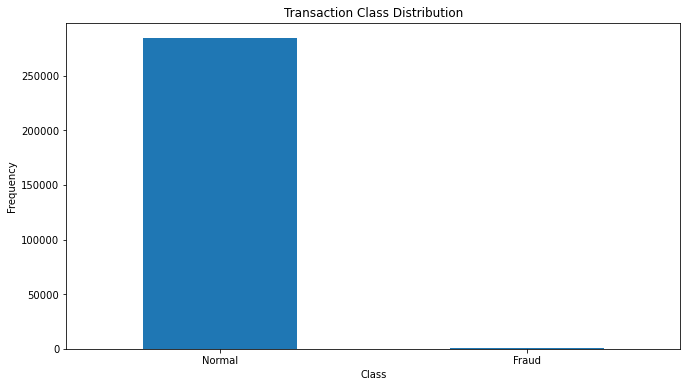

In [5]:
# Knowing the number of Classes that exist mainly and the frequency
rcParams['figure.figsize'] = 11, 6
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'])

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

##### We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [6]:
# Get the Fraud and the normal dataset 

fraud = data[data['Class']==1]

normal = data[data['Class']==0]

In [7]:
print(fraud.shape,normal.shape)

(492, 31) (284315, 31)


In [8]:
# We need to analyze more amount of information from the transaction data
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [9]:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

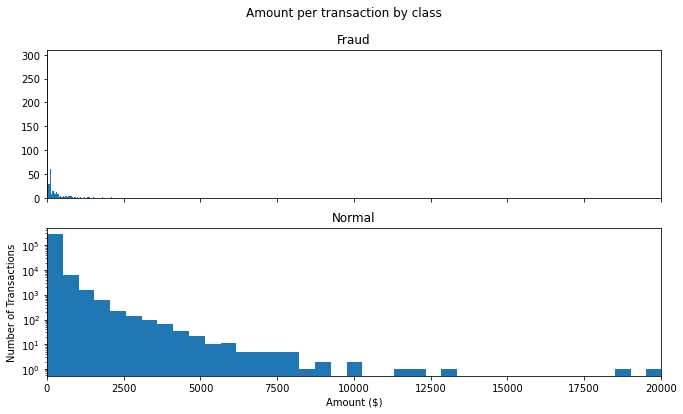

In [10]:
# Try to explore the transaction waves in realtion to the amount
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

In [11]:
#creating target series
target=data['Class']
target

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64

In [12]:
#dropping the target variable from the data set to clean the dataset
data.drop('Class',axis=1,inplace=True)
data.shape

(284807, 30)

In [13]:
#converting them to numpy arrays
X=np.array(data)
y=np.array(target)
print(X)
print(y)

[[ 0.00000000e+00 -1.35980713e+00 -7.27811733e-02 ...  1.33558377e-01
  -2.10530535e-02  1.49620000e+02]
 [ 0.00000000e+00  1.19185711e+00  2.66150712e-01 ... -8.98309914e-03
   1.47241692e-02  2.69000000e+00]
 [ 1.00000000e+00 -1.35835406e+00 -1.34016307e+00 ... -5.53527940e-02
  -5.97518406e-02  3.78660000e+02]
 ...
 [ 1.72788000e+05  1.91956501e+00 -3.01253846e-01 ...  4.45477214e-03
  -2.65608286e-02  6.78800000e+01]
 [ 1.72788000e+05 -2.40440050e-01  5.30482513e-01 ...  1.08820735e-01
   1.04532821e-01  1.00000000e+01]
 [ 1.72792000e+05 -5.33412522e-01 -1.89733337e-01 ... -2.41530880e-03
   1.36489143e-02  2.17000000e+02]]
[0 0 0 ... 0 0 0]


In [14]:
print(X.shape)
print(y.shape)

(284807, 30)
(284807,)


In [15]:
#distribution of the target variable
print(len(y[y==1]))
print(len(y[y==0]))

492
284315


#### splitting the data set into train and test (75:25)

In [16]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(213605, 30) (71202, 30) (213605,) (71202,)


#### applyting SMOTE to oversample the minority class

In [17]:
sm=SMOTE(random_state=2)
X_sm,y_sm=sm.fit_resample(X_train,y_train)
print(X_sm.shape,y_sm.shape)

(426448, 30) (426448,)


## Building the model
#### Logistic Regression model

In [18]:
logreg=LogisticRegression()
logreg.fit(X_sm,y_sm)
y_logreg=logreg.predict(X_test)
y_logreg_prob=logreg.predict_proba(X_test)[:,1]

C:\Users\abu_s\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Evaluating Model Performance 

In [19]:
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test,y_logreg))
print("Accuracy:\n",metrics.accuracy_score(y_test,y_logreg))
print("Precision:\n",metrics.precision_score(y_test,y_logreg))
print("Recall:\n",metrics.recall_score(y_test,y_logreg))
print("AUC:\n",metrics.roc_auc_score(y_test,y_logreg_prob))
auc=metrics.roc_auc_score(y_test,y_logreg_prob)

Confusion Matrix:
 [[70261   830]
 [   19    92]]
Accuracy:
 0.9880761776354596
Precision:
 0.09978308026030369
Recall:
 0.8288288288288288
AUC:
 0.9506834977780667


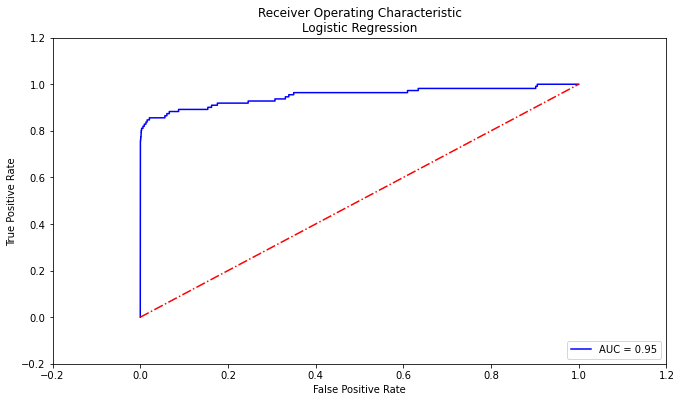

In [20]:
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y_test,y_logreg_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nLogistic Regression')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### KNN model

In [21]:
#K Nearest Neighbors
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_sm,y_sm)
y_knn=knn.predict(X_test)
y_knn_prob=knn.predict_proba(X_test)[:,1]

#### Evaluating Model Performance

In [22]:
print(metrics.confusion_matrix(y_test,y_knn))
print(metrics.accuracy_score(y_test,y_knn))
print(metrics.precision_score(y_test,y_knn))
print(metrics.recall_score(y_test,y_knn))
print(metrics.roc_auc_score(y_test,y_knn_prob))


[[67323  3768]
 [   62    49]]
0.9462093761411197
0.012837306785433586
0.44144144144144143
0.711052171300304


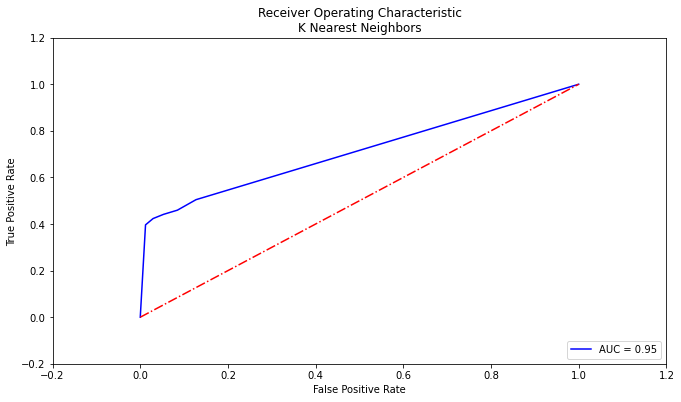

In [23]:
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y_test,y_knn_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nK Nearest Neighbors')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### Random Forest model

In [ ]:
rf=RandomForestClassifier(random_state=3)
rf.fit(X_sm,y_sm)
y_rf=rf.predict(X_test)
y_rf_prob=rf.predict_proba(X_test)[:,1]

#### Evaluating Model Performance

In [ ]:
#Performance metrics evaluation
print("Confusion Matrix:\n",metrics.confusion_matrix(y_test,y_rf))
print("Accuracy:\n",metrics.accuracy_score(y_test,y_rf))
print("Precision:\n",metrics.precision_score(y_test,y_rf))
print("Recall:\n",metrics.recall_score(y_test,y_rf))
print("AUC:\n",metrics.roc_auc_score(y_test,y_rf_prob))
auc=metrics.roc_auc_score(y_test,y_rf_prob)

In [ ]:
#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y_test,y_rf_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()